In [1]:
from dolfin import *
parameters["form_compiler"]["representation"] = 'quadrature'
parameters["form_compiler"]["representation"] = "tsfc"
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import numpy as np
import matplotlib.pyplot as plt

# Test for PETSc
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

# Set backend to PETSC
parameters["linear_algebra_backend"] = "PETSc"

def build_nullspace(V, x):
    """Function to build nullspace for 2D/3D elasticity"""

    # Get geometric dim
    gdim = V.mesh().geometry().dim()
    assert gdim == 2 or gdim == 3

    # Set dimension of nullspace
    dim = 3 if gdim == 2 else 6

    # Create list of vectors for null space
    nullspace_basis = [x.copy() for i in range(dim)]

    # Build translational null space basis
    for i in range(gdim):
        V.sub(i).dofmap().set(nullspace_basis[i], 1.0);

    # Build rotational null space basis
    if gdim == 2:
        V.sub(0).set_x(nullspace_basis[2], -1.0, 1);
        V.sub(1).set_x(nullspace_basis[2], 1.0, 0);
    elif gdim == 3:
        V.sub(0).set_x(nullspace_basis[3], -1.0, 1);
        V.sub(1).set_x(nullspace_basis[3],  1.0, 0);

        V.sub(0).set_x(nullspace_basis[4],  1.0, 2);
        V.sub(2).set_x(nullspace_basis[4], -1.0, 0);

        V.sub(2).set_x(nullspace_basis[5],  1.0, 1);
        V.sub(1).set_x(nullspace_basis[5], -1.0, 2);

    for x in nullspace_basis:
        x.apply("insert")

    return VectorSpaceBasis(nullspace_basis)

Generating mesh with CGAL 3D mesh generator


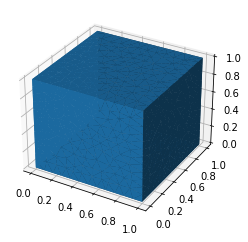

In [4]:
from mshr import *
cube = Box(Point(0, 0, 0),Point(1, 1, 1))
domain = cube
mesh = generate_mesh(domain, 20)
plot(mesh);

In [5]:
E_value = float(input("Please enter the value for Elastic Modulus: ")) ## enter 20e3 if E = 20 GPa [Eacrylic = 3 GPa]
E = Constant(E_value)
nu_value = float(input("Please enter the value for Poisson's Ratio: ")) ## acrylic sheet = 0.37
nu = Constant(nu_value)
sig0_value = float(input("Please enter the value for Yield Strength: ")) ## enter 250. if sig_YS = 250 MPa, sigYS = 75 MPa
sig0 = Constant(sig0_value) 

lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
Et = E/100.  
H = E*Et/(E-Et)  

Please enter the value for Elastic Modulus: 3e3
Please enter the value for Poisson's Ratio: 0.37
Please enter the value for Yield Strength: 75


In [6]:
deg_u = 2 
deg_stress = 2
V = VectorFunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=6, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)

In [7]:
sig = Function(W)
sig_old = Function(W)
n_elas = Function(W)
beta = Function(W0)
p = Function(W0, name="Cumulative plastic strain")
u = Function(V, name="Total displacement")
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)
P0 = FunctionSpace(mesh, "DG", 0)
p_avg = Function(P0, name="Plastic strain")

In [8]:
x0_value = int(input("Please enter the 0, 1 or 2 to decide x[0], x[1] or x[2]: "))
a = float(input("Enter lower bound value: "))
b = float(input("Enter upper bound value: "))

class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[x0_value], a, 0.01)
    
class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[x0_value], b, 0.01)

boundaries = MeshFunction("size_t", mesh, mesh.geometry().dim() - 1)

bottom().mark(boundaries, 1)
top().mark(boundaries, 2)

loading = Expression("-t", t=0, degree=1)

bc_bottom = DirichletBC(V, Constant((0., 0., 0.)), boundaries, 1)

ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

bc_u = [bc_bottom]

def F_ext(v):
    return loading*dot(n, v)*ds(2)

Please enter the 0, 1 or 2 to decide x[0], x[1] or x[2]: 2
Enter lower bound value: 0
Enter upper bound value: 1


In [9]:
def eps(v):
    e = sym(grad(v))
    return as_tensor([[e[0, 0], e[0, 1], e[0, 2]],
                      [e[0, 1], e[1, 1], e[1, 2]],
                      [e[0, 2], e[1, 2], e[2, 2]]])

def sigma(eps_el):
    return lmbda*tr(eps_el)*Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return as_tensor([[X[0], X[3], X[4]],
                      [X[3], X[1], X[5]],
                      [X[4], X[5], X[2]]])

In [10]:
ppos = lambda x: (x+abs(x))/2.
def proj_sig(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = dev(sig_elas)
    sig_eq = sqrt(3/2.*inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu*dp/sig_eq
    new_sig = sig_elas-beta*s
    return as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1], new_sig[0, 2], new_sig[1, 2]]), \
           as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1], n_elas[0, 2], n_elas[1, 2]]), \
           beta, dp

In [11]:
def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*inner(N_elas, e)*N_elas-2*mu*beta*dev(e)

In [12]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

a = inner(eps(v), sigma_tang(eps(u_)))*dxm
L = -inner(eps(u_), as_3D_tensor(sig))*dxm + F_ext(u_)

In [13]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
sig_n1 = as_3D_tensor(sig)
s1 = dev(sig_n1)
Vs = FunctionSpace(mesh, "DG", 0)
sig_eq1 = local_project(sqrt(3/2.*inner(s1, s1)), Vs)
vm = sig_eq1.vector().max()
print("max_vonmises: ",vm)

max_vonmises:  0.0


In [15]:
w  = float(input("Enter the value of plastic strain above which the simulation stops: "))
w1 = float(input("Enter x-coordinate of displacement of a point: "))
w2 = float(input("Enter y-coordinate of displacement of a point: "))
w3 = float(input("Enter z-coordinate of displacement of a point: "))
w4 = int(input("Enter the displacement in which direction; 0, 1 or 2 : "))

Enter the value of plastic strain above which the simulation stops: 0.05
Enter x-coordinate of displacement of a point: 0.5
Enter y-coordinate of displacement of a point: 0.5
Enter z-coordinate of displacement of a point: 1.
Enter the displacement in which direction; 0, 1 or 2 : 2


In [16]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 300
load_steps = np.linspace(0, 150, Nincr+1)[1:]
results = np.zeros((Nincr+1, 2))

for (i, t) in enumerate(load_steps):
    
    sig_n1 = as_3D_tensor(sig)
    s1 = dev(sig_n1)
    Vs = FunctionSpace(mesh, "DG", 0)
    sig_eq1 = local_project(sqrt(3/2.*inner(s1, s1)), Vs)
    vm = sig_eq1.vector().max()
    print("vm: ",vm)
        
    loading.t = t

    A, b = assemble_system(a, L, bc_u)
    b0 = b.norm("l2")
    b1 = b0
    Du.interpolate(Constant((0, 0, 0)))
    print("Increment:", str(i+1))
    niter = 0
    while b1/b0 > tol and niter < Nitermax:
        
        null_space = build_nullspace(V, du.vector())
        as_backend_type(A).set_near_nullspace(null_space)

        pc = PETScPreconditioner("petsc_amg")

        PETScOptions.set("mg_levels_ksp_type", "chebyshev")
        PETScOptions.set("mg_levels_pc_type", "jacobi")

        PETScOptions.set("mg_levels_esteig_ksp_type", "cg")
        PETScOptions.set("mg_levels_ksp_chebyshev_esteig_steps", 50)

        solver = PETScKrylovSolver("cg", pc)
        solver.parameters["monitor_convergence"] = False

        solver.set_operator(A);

        solver.solve(du.vector(), b);
                
        Du.assign(Du+du)
        
        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)
        
        local_project(sig_, W, sig)
        local_project(n_elas_, W, n_elas)
        local_project(beta_, W0, beta)
        
        A, b = assemble_system(a, L, bc_u)
        b1 = b.norm("l2")
        print("    Residual:", b1)
        niter += 1
        
    u.assign(u+Du)
    p.assign(p+local_project(dp_, W0))
    sig_old.assign(sig)
    p_avg.assign(project(p, P0))
    k = p_avg.vector().max()
    print("max_plastic_strain: ", k)
    if k > w:
        x= P0.tabulate_dof_coordinates()
        max_index = np.argmax(p_avg.vector()[:])
        print("Max_plastic_strain at:", x[max_index])
        break
    results[i+1, :] = (u(w1, w2, w2)[w4], t)

vm:  0.0
Increment: 1
    Residual: 9.606730632779573e-06
    Residual: 5.97914955558384e-11
max_plastic_strain:  0.0
vm:  0.7881246107998532
Increment: 2
    Residual: 9.606735210365369e-06
    Residual: 5.979146323191944e-11
max_plastic_strain:  0.0
vm:  1.5762492217151096
Increment: 3
    Residual: 9.606735210636208e-06
    Residual: 5.979159268276165e-11
max_plastic_strain:  0.0
vm:  2.3643738326303656
Increment: 4
    Residual: 9.60673521059977e-06
    Residual: 5.979155751753819e-11
max_plastic_strain:  0.0
vm:  3.1524984435456225
Increment: 5
    Residual: 9.606735210046637e-06
    Residual: 5.97915366119442e-11
max_plastic_strain:  0.0
vm:  3.940623054460878
Increment: 6
    Residual: 9.606735210475737e-06
    Residual: 5.979156708736766e-11
max_plastic_strain:  0.0
vm:  4.728747665376135
Increment: 7
    Residual: 9.606735210236096e-06
    Residual: 5.979139976068547e-11
max_plastic_strain:  0.0
vm:  5.516872276291391
Increment: 8
    Residual: 9.606735210349836e-06
    Residu

    Residual: 5.979163566519393e-11
max_plastic_strain:  0.0
vm:  48.86372587663048
Increment: 63
    Residual: 9.606735210420045e-06
    Residual: 5.979137679837914e-11
max_plastic_strain:  0.0
vm:  49.651850487545744
Increment: 64
    Residual: 9.606735210413314e-06
    Residual: 5.979156921477585e-11
max_plastic_strain:  0.0
vm:  50.439975098461
Increment: 65
    Residual: 9.60673521046734e-06
    Residual: 5.979157756883229e-11
max_plastic_strain:  0.0
vm:  51.22809970937625
Increment: 66
    Residual: 9.606735210653663e-06
    Residual: 5.979139287667751e-11
max_plastic_strain:  0.0
vm:  52.01622432029151
Increment: 67
    Residual: 9.606735210251895e-06
    Residual: 5.979155066845671e-11
max_plastic_strain:  0.0
vm:  52.80434893120677
Increment: 68
    Residual: 9.606735210473465e-06
    Residual: 5.97914954817781e-11
max_plastic_strain:  0.0
vm:  53.59247354212202
Increment: 69
    Residual: 9.606735210252019e-06
    Residual: 5.979156066647761e-11
max_plastic_strain:  0.0
vm: 

Increment: 114
    Residual: 0.000847300383532798
    Residual: 1.696002178236367e-07
    Residual: 2.89132898609165e-12
max_plastic_strain:  0.00738704370011328
vm:  75.22384980909433
Increment: 115
    Residual: 0.0003857436382573109
    Residual: 1.6290155806353128e-07
    Residual: 3.498143910377309e-12
max_plastic_strain:  0.00784924331923458
vm:  75.23785585815861
Increment: 116
    Residual: 0.0008010557303462109
    Residual: 7.217681927177027e-08
    Residual: 7.810245361729447e-13
max_plastic_strain:  0.008319770355065705
vm:  75.25211425318382
Increment: 117
    Residual: 0.0013493459428910613
    Residual: 3.192687084696385e-07
    Residual: 4.609194336876854e-12
max_plastic_strain:  0.008804957762117767
vm:  75.26681690188236
Increment: 118
    Residual: 0.0007632443769489615
    Residual: 2.794947587492986e-07
    Residual: 8.05735803938586e-12
max_plastic_strain:  0.009299750385925752
vm:  75.28181061775533
Increment: 119
    Residual: 0.0007941188261020389
    Residual:

In [17]:
x = results[:, 0]
last_non_zero_index = len(x) - 1
while last_non_zero_index >= 0 and x[last_non_zero_index] == 0:
    last_non_zero_index -= 1
x = x[:last_non_zero_index + 1]

y = results[:, 1]
last_non_zero_index = len(y) - 1
while last_non_zero_index >= 0 and y[last_non_zero_index] == 0:
    last_non_zero_index -= 1
y = y[:last_non_zero_index + 1]

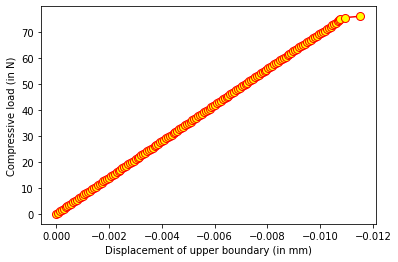

In [18]:
import matplotlib.pyplot as plt
save_path = "/mnt/d/Research Projects/FEniCS/design/plots files"

plt.plot(x, y, "-o", color="red", markerfacecolor="yellow", markersize=8)
plt.xlabel("Displacement of upper boundary (in mm)")
plt.ylabel(r"Compressive load (in N)")
plt.gca().invert_xaxis()

# Set DPI (dots per inch) for the saved image and specify the full path
# save_file_path = os.path.join(save_path, "circle3x4.png")
# plt.savefig(save_file_path, dpi=900)

# Show the plot (optional)
plt.show()

In [19]:
file_results = XDMFFile("elasto_plastic3d_cube.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_results.write(u, 0.)
file_results.write(p_avg, 0.)